**Install Dependencies**

In [ ]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

**Import Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import copy


**Image Loading & Preprocessing**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing function
loader = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

def image_loader(image_name):
    image = Image.open(image_name).convert("RGB")
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

content_img = image_loader("content.jpeg")
style_img = image_loader("style.jpeg")


**Display Images**

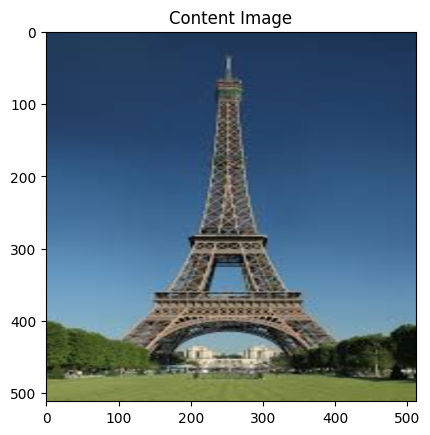

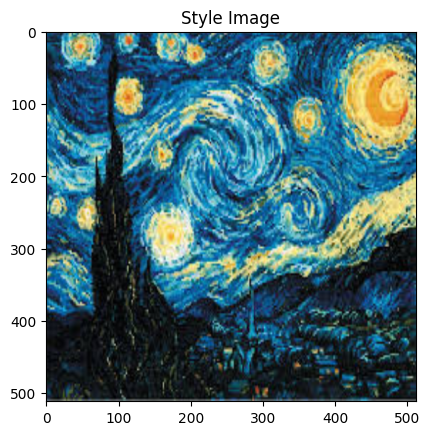

In [ ]:
def imshow(tensor, title=None):
    unloader = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.],
                             std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                             std=[1., 1., 1.]),
    ])
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.pause(0.001)

imshow(content_img, title='Content Image')
imshow(style_img, title='Style Image')


**Define Model and Loss Functions**

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Helper to calculate gram matrix
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 82.2MB/s]


**Build the Style Transfer Model**

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

# Normalization module
class Normalization(nn.Module):
    def __init__(self):
        super().__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


**Assemble the Full Model**

In [ ]:
def get_style_model_and_losses(cnn, style_img, content_img):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization().to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_img).detach()
            style_loss = StyleLoss(target)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim off unused layers
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break
    model = model[:i+1]

    return model, style_losses, content_losses


**Run the Optimization**

Optimizing...
Step 1 | Style Loss: 8.8133 | Content Loss: 0.0000
Step 51 | Style Loss: 15.7714 | Content Loss: 141.8658
Step 101 | Style Loss: 15.5910 | Content Loss: 130.0724
Step 151 | Style Loss: 15.4312 | Content Loss: 122.7665
Step 201 | Style Loss: 15.2889 | Content Loss: 117.3369
Step 251 | Style Loss: 15.1628 | Content Loss: 113.0316
Step 300 | Style Loss: 15.0516 | Content Loss: 109.5523


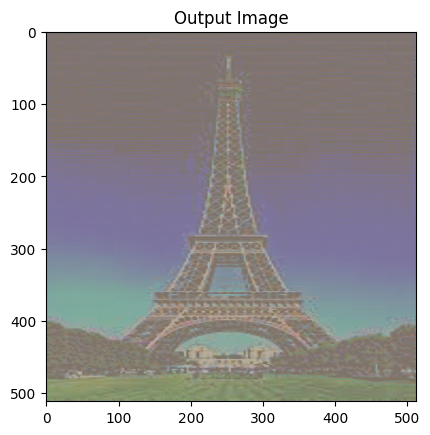

In [ ]:
input_img = content_img.clone().detach()
input_img.requires_grad_(True)

model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)

# Switch to Adam optimizer
optimizer = optim.Adam([input_img], lr=0.003)

style_weight = content_weight = 1

print("Optimizing...")
steps = 300

for step in range(steps):
    optimizer.zero_grad()
    model(input_img)

    style_score = sum([sl.loss for sl in style_losses])
    content_score = sum([cl.loss for cl in content_losses])
    loss = style_score * style_weight + content_score * content_weight

    # Backward and update
    loss.backward()
    optimizer.step()

    # Clamp to prevent overflow
    input_img.data.clamp_(0, 1)

    if step % 50 == 0 or step == steps - 1:
        print(f"Step {step+1} | Style Loss: {style_score.item():.4f} | Content Loss: {content_score.item():.4f}")
input_img.data.clamp_(0, 1)
imshow(input_img.detach(), title='Output Image')

**Save the Output**

In [ ]:
output = input_img.cpu().clone().squeeze(0)
output = transforms.ToPILImage()(output)
output.save("stylized_output.jpg")
